In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mv_normal

## Bayesian Linear Regression

The original least squares approach, assumes a target $t$ with additive  Gaussian noise,
$$t = y(\vec{x}, \vec{w}) + \epsilon $$

where $\epsilon \sim \mathcal{N}(0, \beta)$. Based on this we write that the probability of $t$ is given by the normal distribution around our function $y(\vec{x}, \vec{w})$.

$$p(t \mid \vec{x}, \vec{w}) = \mathcal{N}(t \mid y(\vec{x}, \vec{w}), \beta^{-1})$$ 

To use this function to predict $t$ for new input vectors based on our current model. The advantage of the Bayesian approach is that we will be able to assign a probability to each value of $t$ given the vector $\vec{x}$. Compared to the point estimates that are given in the least squares approach. We are able to give the uncertainty in our estimates.


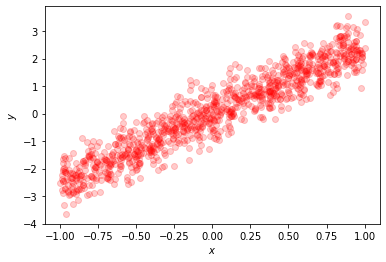

In [24]:
m = 1000
noise_std = 0.5

x_star = np.array([2.5]).reshape(1,)
A = np.random.uniform(low=-1, high=1, size=(m, 1))
y = A @ x_star + noise_std * np.random.standard_normal((m,))

def plot_data_1d(A, y):
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.plot(A[:, 0], y, 'ro', alpha=0.2)

plot_data_1d(A, y)

The model is a simple linear model with parameters $\{w_j\}$, 
$$y(\vec{x}, \vec{w}) = w_0 + \sum_{j=1}^{M-1} w_j\phi_j(\vec{x})$$ 
Where we can transform the input with _basis functions_ given by $\{\phi_j(\vec{x})\}$, with a total of $M$ parameters. Here we take $\phi_0(\vec{x}) = 1$.

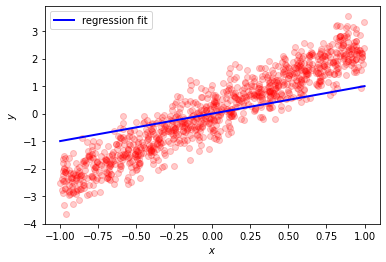

In [26]:
def plot_fit(A, y, params, phi=lambda x: x, x_lim=1, n=100):
    x_values = np.linspace(-x_lim, x_lim, n)
    
    # Add additional dummy value for the intercept
    A_phi = np.vstack((np.ones_like(x_values), x_values))
    A_phi = phi(A_phi)
    y_values = np.array(params).dot(A_phi)
    
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.plot(A[:, 0], y, 'ro', alpha=0.2)
    plt.plot(x_values, y_values, '-b', linewidth=2, label='regression fit')
    plt.legend()

# Passing intercept, and slope    
plot_fit(A, y, [0, 1])

## Bayesian Approach
We introduce a prior probability distribution over the model parameters $\vec{w}$ and consider $\beta$ the precision parameter from our initial model as a known constant. This will give our **conjugate prior** for the weight parameters a normal distribution.

$$p(\vec{w}) = \mathcal{N}(\vec{w} \mid \vec{m}_0, \vec{S}_0) $$

where $\vec{m}_0$ is our prior mean estimation and $\vec{S}_0$ is our prior covariance estimation of the distribution. When multiplying the prior with the likelihood this will again give us a normal distribution as our posterior.

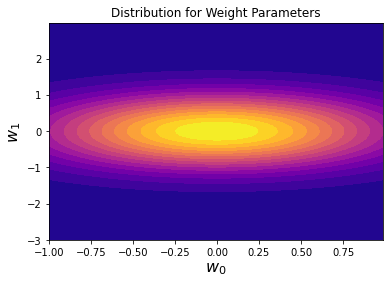

In [27]:
# Setting the values for the prior
alpha = 2.0
beta = (1/alpha)**2
m0 = np.array([0., 0.])
S0 = 1/alpha*np.identity(2)

# Prior
prior = mv_normal(mean=m0, cov=S0)

def visualize_posterior(lim_x, lim_y, posterior):
    x, y = np.mgrid[-lim_x:lim_x:.01, -lim_y:lim_y:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    
    plt.contourf(x, y, posterior.pdf(pos), 20, cmap='plasma')
    plt.xlabel('$w_0$', fontsize=16)
    plt.ylabel('$w_1$', fontsize=16)
    plt.title('Distribution for Weight Parameters')

    
visualize_posterior(lim_x=1, lim_y=3, posterior=prior)

## Predictive Distribution

The goal is to create a predictive distribution for new inputs $\vec{x}$ based on the data we have seen:

$$p(t \mid \vec{x}, D)$$

Using the marginalization rule $p(x) = \int p(x, y) dy$ to integrate over our parameter values $\vec{w}$:

$$p(t \mid \vec{x}, D) = \int p(t, \vec{w} \mid \vec{x}, D) d\vec{w} $$

Applying the product rule gives:

$$p(t \mid \vec{x}, D) = \int p(t \mid \vec{x}, \vec{w})p(\vec{w} \mid D) d\vec{w}$$

The first term in our integral quantifies our model which uses a specific set of parameters, and the second term gives the probability of these parameters values conditioned on the observed dataset. Using Bayes's Theorem to evaluate this conditional probability to take the observational data into account: 

$$p(\vec{w} \mid D) = \frac{p(\vec{w})p(D \mid \vec{w})}{p(D)} = \frac{p(\vec{w})\mathcal{L}(\vec{w} \mid D)}{p(D)}$$  

where $\mathcal{L}(\vec{w} \mid D) = p(D \mid \vec{w})$ is the likelihood of paramters $\vec{w}$ given observational data $D$. 

$\dots$

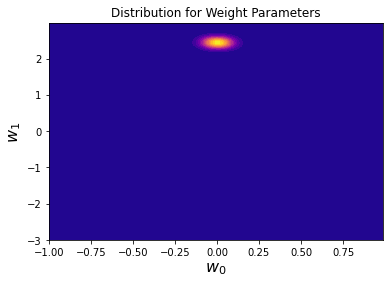

In [31]:
def calculate_posterior(A, y, beta, prior):
    A_phi = np.ones((A.shape[0], A.shape[1]+1))
    A_phi[:, 1] = A.reshape(-1)
    
    SN = np.linalg.inv(np.linalg.inv(prior.cov) + beta * A_phi.T.dot(A_phi))
    
    # m_N = S_N(S_0^-1 m_0 + \beta \Phi^\top t
    S0 = np.linalg.inv(prior.cov)
    mN = SN.dot(S0.dot(prior.mean) + beta * A_phi.T.dot(y).squeeze())
    return mv_normal(mean=mN, cov=SN)


posterior = calculate_posterior(A, y, beta, prior)
visualize_posterior(lim_x=1, lim_y=3, posterior=posterior)

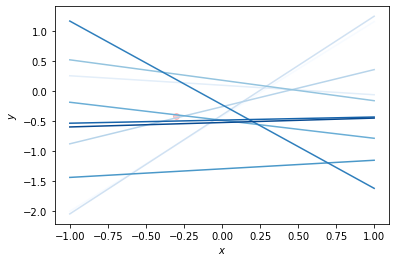

In [37]:
def plot_posterior_fit(A, y, posterior, n=10):
    
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.plot(A[:, 0], y, 'ro', alpha=0.2)
    
    cmap = matplotlib.colormaps.get_cmap('Blues')
    colors = [cmap(i/n) for i in range(n)]

    for i in range(n):
        params = posterior.rvs(1)
        x_values = np.linspace(-1, 1, 100)
        y_values = params[1] * x_values + params[0]
        plt.plot(x_values, y_values, color=colors[i])

# Plot the fit of the prior
plot_posterior_fit(A[:1], y[:1], prior)

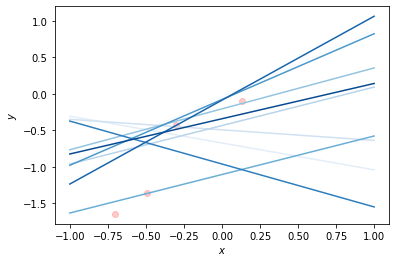

In [38]:
M = 4
posterior = calculate_posterior(A[:M], y[:M], beta = 1.0, prior=prior)
plot_posterior_fit(A[:M], y[:M], posterior)

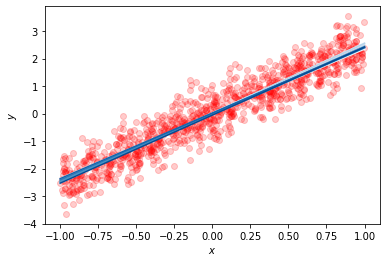

In [39]:
# Plot the fit with all data
posterior = calculate_posterior(A, y, beta = 1.0, prior=prior)
plot_posterior_fit(A, y, posterior)

In [444]:
# Weights W_0, and W_1 respectively.
posterior.rvs(1)

array([-0.04482434,  2.35829155])

Using the posterior $p(\vec{w} \mid \vec{t}, \alpha, \beta)$ we want quantify the confidence intervals around the fit of our linear regression model using:

$$ \sigma_N^2(\vec{x}) = \frac{1}{\beta} + \vec{\phi}(\vec{x})^T\vec{S}_N\vec{\phi}(\vec{x})$$

The first term is the variance of the gaussian noise intrinsic in the data, and the second term depends on the posterior covariance $\vec{S}_N$. This shows that even if our posterior covariance shrinks to zero, we still have the noise in our data limiting our estimation.

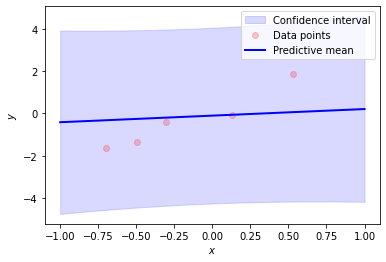

In [42]:
def plot_posterior_with_confidence(A, y, beta, posterior):
    x_new = np.linspace(-1, 1, 100).reshape(-1)
    A_new = np.ones((len(x_new), 2))
    A_new[:, 1] = x_new
    
    # Calculate mean and std of predictions
    means = A_new.dot(posterior.mean)
    stds = np.sqrt(1/beta + np.sum(A_new.dot(posterior.cov) * A_new, axis=1))
    
    plt.fill_between(x_new, means - 2*stds, means + 2*stds, color='b', 
                 alpha=0.15, label='Confidence interval')
    
    plt.plot(A, y, 'ro', alpha=0.2, label='Data points')
    plt.plot(x_new, means, label='Predictive mean', color='b', linewidth=2)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()
    plt.show()

M = 5
posterior = calculate_posterior(A[:M], y[:M], beta=beta, prior=prior)
plot_posterior_with_confidence(A[:M], y[:M], beta=beta, posterior=posterior)

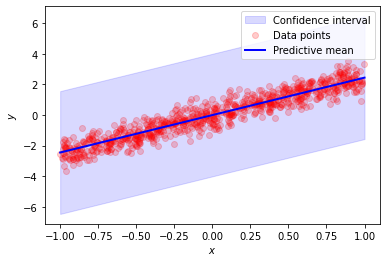

In [43]:
M = 800
posterior = calculate_posterior(A[:M], y[:M], beta=beta, prior=prior)
plot_posterior_with_confidence(A[:M], y[:M], beta=beta, posterior=posterior)